# Предсказание температуры стали

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. 

Данные состоят из файлов, полученных из разных источников, с различных этапов производственного процесса.

Целевой показатель - конечный замер температуры.

Оценивать качество моделей будем метрикой МАЕ.

## План исследования

- Исследование исходных данных на аномалии, пропуски и другие особенности с целью получения для модели качественные данные;
- Поиск новых признаков;
- Определение и исследование взаимосвязи между признаками и целевым показателем;
- Подготовка данных для анализа моделями;
- Исследование качества модели путем расчета метрики МАЕ;
- Поиск лучшей модели;
- Выводы.

## Библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import catboost as cb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Датасет

In [2]:
arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
bulk_vol = pd.read_csv('/datasets/final_steel/data_bulk.csv')
bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
wire_vol = pd.read_csv('/datasets/final_steel/data_wire.csv')
wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [3]:
def inf(data):
    return display(data.head()), data.info(), data.shape, display(data.describe()), print('Партии:',
                                                                                          len(data['key'].unique()));

### Электроды

In [4]:
inf(arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Партии: 3214


(None, None, (14876, 5), None, None)

In [5]:
display(arc.loc[arc['Реактивная мощность'] < 0])

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [6]:
arc = arc.loc[~(arc['key'] == 2116)]

Данные без пропусков, выявлена аномалия в реактивной мощности, удалена вся партия.

In [7]:
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'], format='%Y%m%d %H:%M:%S.%f')

In [8]:
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'], format='%Y%m%d %H:%M:%S.%f')

In [9]:
arc['Время нагрева дугой'] = (arc['Конец нагрева дугой'] - arc['Начало нагрева дугой']).dt.total_seconds()

In [10]:
arc['Полная мощность'] = np.sqrt(arc['Активная мощность']**2 + arc['Активная мощность']**2)

Из имеющихся данных выведены новые данные: время нагрева дугой и полная мощность.

In [11]:
arc = arc.rename({'Начало нагрева дугой':'start',
                  'Конец нагрева дугой':'heat_end',
                  'Активная мощность':'active_power',
                 'Реактивная мощность':'reactive_power',
                 'Время нагрева дугой':'heat_time',
                 'Полная мощность':'power'}, axis=1)

In [12]:
arc = arc.pivot_table(index='key', values=['heat_end',
                                           'active_power',
                                           'reactive_power',
                                           'heat_time',
                                           'power'], aggfunc={'heat_end':'last','active_power':'sum',
                                                                            'reactive_power':'sum',
                                                                            'heat_time':'sum',
                                                                            'power':'sum'})

In [13]:
arc.reset_index(level='key')

,key,active_power,heat_end,heat_time,power,reactive_power
0,1,4.878147,2019-05-03 11:28:37,1098.0,6.898741,3.183241
1,2,3.052598,2019-05-03 11:53:18,811.0,4.317026,1.998112
2,3,2.525882,2019-05-03 12:32:19,655.0,3.572137,1.599076
3,4,3.209250,2019-05-03 12:57:50,741.0,4.538565,2.060298
4,5,3.347173,2019-05-03 13:33:55,869.0,4.733617,2.252643
...,...,...,...,...,...,...
3208,3237,3.932467,2019-08-31 23:03:48,909.0,5.561348,2.828459
3209,3238,2.106529,2019-08-31 23:41:28,546.0,2.979081,1.681182
3210,3239,4.666754,2019-09-01 02:15:43,1216.0,6.599787,3.111617
3211,3240,2.984083,2019-09-01 03:34:08,839.0,4.220131,2.483267


### Присадка объем

In [14]:
inf(bulk_vol)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Партии: 3129


(None, None, (3129, 16), None, None)

In [15]:
bulk_vol = bulk_vol.fillna(0)

In [16]:
bulk_vol['bulk_total'] = bulk_vol.iloc[:, 1:].sum(axis=1)

In [17]:
bulk_vol.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,bulk_total
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0


Видим 15 видов присадок, пропущенные значения заменены на ноль. Чаще всего используется 5 видов.

### Продувка газом

In [21]:
inf(gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Партии: 3239


(None, None, (3239, 2), None, None)

In [22]:
gas = gas.rename({'Газ 1':'gas'}, axis=1)

In [23]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key    3239 non-null int64
gas    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Продувка газом не привязана ко времени, но, похоже, применяется к каждой партии (наибольшее количество уникальных партий среди всех таблиц - 3239, причем соответсвует количеству строк, т.е. одна партия - один продув).

### Температура

In [24]:
inf(temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Партии: 3216


(None, None, (15907, 3), None, None)

In [25]:
temp.iloc[:, 1] = temp.iloc[:, 1].apply(pd.to_datetime, errors='coerce')

In [26]:
temp['Температура'] = temp['Температура'].fillna(0)

Последнее измерение по партии - целевой признак. На вскидку, по каждой партии производтся около 5 замеров.

Нам важна темепература на входе и в конце.

Время приведено к datetime, пропущенные значения заменены на ноль.

### Проволока объем

In [27]:
inf(wire_vol)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Партии: 3081


(None, None, (3081, 10), None, None)

In [28]:
wire_vol = wire_vol.fillna(0)

In [29]:
wire_vol['Wire_total'] = wire_vol.iloc[:, 1:].sum(axis=1)

In [30]:
wire_vol.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Wire_total
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


Из исходных данных не понятно, различается ли состав добавляемой проволоки, однако видно, что добавления иногда происходят из разных партий.

Добавил данные по суммарному объему.

## Объединение таблиц

In [33]:
end_temp = temp.pivot_table(index='key',  values = ['Температура', 'Время замера'], aggfunc=['last'])

In [34]:
end_temp.head()

last            
           Время замера Температура
key                                
1   2019-05-03 11:30:39      1613.0
2   2019-05-03 11:59:12      1602.0
3   2019-05-03 12:34:57      1599.0
4   2019-05-03 12:59:25      1625.0
5   2019-05-03 13:36:01      1602.0

In [35]:
end_temp.set_axis(['target_time', 'target_temp'], 1, inplace=True)

In [36]:
end_temp.reset_index(level='key')

,key,target_time,target_temp
0,1,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:36:01,1602.0
...,...,...,...
3211,3237,2019-08-31 23:05:43,0.0
3212,3238,2019-08-31 23:43:00,0.0
3213,3239,2019-09-01 02:24:15,0.0
3214,3240,2019-09-01 03:35:16,0.0


In [37]:
start_temp = temp.pivot_table(index='key',  values = ['Температура', 'Время замера'], aggfunc=['first'])

In [38]:
start_temp.set_axis(['start_time', 'first_temp'], 1, inplace=True)

In [39]:
start_temp.reset_index(level='key')

,key,start_time,first_temp
0,1,2019-05-03 11:16:18,1571.0
1,2,2019-05-03 11:37:27,1581.0
2,3,2019-05-03 12:13:17,1596.0
3,4,2019-05-03 12:52:57,1601.0
4,5,2019-05-03 13:23:19,1576.0
...,...,...,...
3211,3237,2019-08-31 22:44:04,1569.0
3212,3238,2019-08-31 23:30:31,1584.0
3213,3239,2019-09-01 01:31:47,1598.0
3214,3240,2019-09-01 02:39:01,1617.0


In [40]:
start_temp = start_temp[['first_temp']].reset_index(level='key')

In [41]:
start_temp.head()

,key,first_temp
0,1,1571.0
1,2,1581.0
2,3,1596.0
3,4,1601.0
4,5,1576.0


Для поиска целевого признака произведена группировка по температуре и времени замера.

In [42]:
end_temp.shape, start_temp.shape

((3216, 2), (3216, 2))

In [43]:
data_temp = end_temp.merge(start_temp, how='left', on='key')

In [44]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 4 columns):
key            3216 non-null int64
target_time    3216 non-null datetime64[ns]
target_temp    3216 non-null float64
first_temp     3216 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 125.6 KB


In [45]:
data_temp = data_temp.query('target_temp > 0').copy()

In [46]:
data_temp.shape

(2477, 4)

In [47]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 4 columns):
key            2477 non-null int64
target_time    2477 non-null datetime64[ns]
target_temp    2477 non-null float64
first_temp     2477 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 96.8 KB


In [48]:
data_gas = data_temp.merge(gas, how='left', on='key')

In [49]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 5 columns):
key            2477 non-null int64
target_time    2477 non-null datetime64[ns]
target_temp    2477 non-null float64
first_temp     2477 non-null float64
gas            2475 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 116.1 KB


In [50]:
data_arc = arc.merge(data_gas, how='right', on='key')

In [51]:
data_arc.shape, data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 10 columns):
key               2477 non-null int64
active_power      2474 non-null float64
heat_end          2474 non-null datetime64[ns]
heat_time         2474 non-null float64
power             2474 non-null float64
reactive_power    2474 non-null float64
target_time       2477 non-null datetime64[ns]
target_temp       2477 non-null float64
first_temp        2477 non-null float64
gas               2475 non-null float64
dtypes: datetime64[ns](2), float64(7), int64(1)
memory usage: 212.9 KB


((2477, 10), None)

In [52]:
data_arc['active'] = (data_arc['target_time'] - data_arc['heat_end']).dt.total_seconds()

Добавлен признак activе - время от окончания нагрева до финального измерения температуры в секундах.

In [53]:
data_arc = data_arc.fillna(0)

In [54]:
data_arc.shape

(2477, 11)

In [55]:
data_bulk = data_arc.merge(bulk_vol, how='left', on='key')

In [56]:
data_bulk.head()

,key,active_power,heat_end,heat_time,power,reactive_power,target_time,target_temp,first_temp,gas,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,bulk_total
0,1,4.878147,2019-05-03 11:28:37,1098.0,6.898741,3.183241,2019-05-03 11:30:39,1613.0,1571.0,29.749986,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
1,2,3.052598,2019-05-03 11:53:18,811.0,4.317026,1.998112,2019-05-03 11:59:12,1602.0,1581.0,12.555561,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
2,3,2.525882,2019-05-03 12:32:19,655.0,3.572137,1.599076,2019-05-03 12:34:57,1599.0,1596.0,28.554793,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0
3,4,3.209250,2019-05-03 12:57:50,741.0,4.538565,2.060298,2019-05-03 12:59:25,1625.0,1601.0,18.841219,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0
4,5,3.347173,2019-05-03 13:33:55,869.0,4.733617,2.252643,2019-05-03 13:36:01,1602.0,1576.0,5.413692,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0


In [57]:
df = data_bulk.merge(wire_vol, how='left', on='key')

In [58]:
df.shape

(2477, 37)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 37 columns):
key               2477 non-null int64
active_power      2477 non-null float64
heat_end          2477 non-null object
heat_time         2477 non-null float64
power             2477 non-null float64
reactive_power    2477 non-null float64
target_time       2477 non-null datetime64[ns]
target_temp       2477 non-null float64
first_temp        2477 non-null float64
gas               2477 non-null float64
active            2477 non-null float64
Bulk 1            2408 non-null float64
Bulk 2            2408 non-null float64
Bulk 3            2408 non-null float64
Bulk 4            2408 non-null float64
Bulk 5            2408 non-null float64
Bulk 6            2408 non-null float64
Bulk 7            2408 non-null float64
Bulk 8            2408 non-null float64
Bulk 9            2408 non-null float64
Bulk 10           2408 non-null float64
Bulk 11           2408 non-null float64
Bulk 12  

In [60]:
df = df.drop(['heat_end', 'target_time'], axis=1)

In [61]:
df.head()

,key,active_power,heat_time,power,reactive_power,target_temp,first_temp,gas,active,Bulk 1,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Wire_total
0,1,4.878147,1098.0,6.898741,3.183241,1613.0,1571.0,29.749986,122.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,3.052598,811.0,4.317026,1.998112,1602.0,1581.0,12.555561,354.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,2.525882,655.0,3.572137,1.599076,1599.0,1596.0,28.554793,158.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,4,3.209250,741.0,4.538565,2.060298,1625.0,1601.0,18.841219,95.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
4,5,3.347173,869.0,4.733617,2.252643,1602.0,1576.0,5.413692,126.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


In [62]:
df.columns = df.columns.str.lower()

In [63]:
df = df.fillna(0)

In [64]:
df.shape

(2477, 35)

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 35 columns):
key               2477 non-null int64
active_power      2477 non-null float64
heat_time         2477 non-null float64
power             2477 non-null float64
reactive_power    2477 non-null float64
target_temp       2477 non-null float64
first_temp        2477 non-null float64
gas               2477 non-null float64
active            2477 non-null float64
bulk 1            2477 non-null float64
bulk 2            2477 non-null float64
bulk 3            2477 non-null float64
bulk 4            2477 non-null float64
bulk 5            2477 non-null float64
bulk 6            2477 non-null float64
bulk 7            2477 non-null float64
bulk 8            2477 non-null float64
bulk 9            2477 non-null float64
bulk 10           2477 non-null float64
bulk 11           2477 non-null float64
bulk 12           2477 non-null float64
bulk 13           2477 non-null float64
bulk 14        

In [66]:
bad_keys = list(df['key'].loc[df['active'] < 0])

In [67]:
df = df.query('key not in @bad_keys')

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2346 entries, 0 to 2476
Data columns (total 35 columns):
key               2346 non-null int64
active_power      2346 non-null float64
heat_time         2346 non-null float64
power             2346 non-null float64
reactive_power    2346 non-null float64
target_temp       2346 non-null float64
first_temp        2346 non-null float64
gas               2346 non-null float64
active            2346 non-null float64
bulk 1            2346 non-null float64
bulk 2            2346 non-null float64
bulk 3            2346 non-null float64
bulk 4            2346 non-null float64
bulk 5            2346 non-null float64
bulk 6            2346 non-null float64
bulk 7            2346 non-null float64
bulk 8            2346 non-null float64
bulk 9            2346 non-null float64
bulk 10           2346 non-null float64
bulk 11           2346 non-null float64
bulk 12           2346 non-null float64
bulk 13           2346 non-null float64
bulk 14        

Удалены данные, где финальный замер температуры проводился до окончания нагрева.

### Выделение целевого признака

In [69]:
X = df.drop('target_temp', 1)

In [70]:
y = df['target_temp']

Сведена итоговая таблица, разделена на признаки и целевую.

### Heatmap

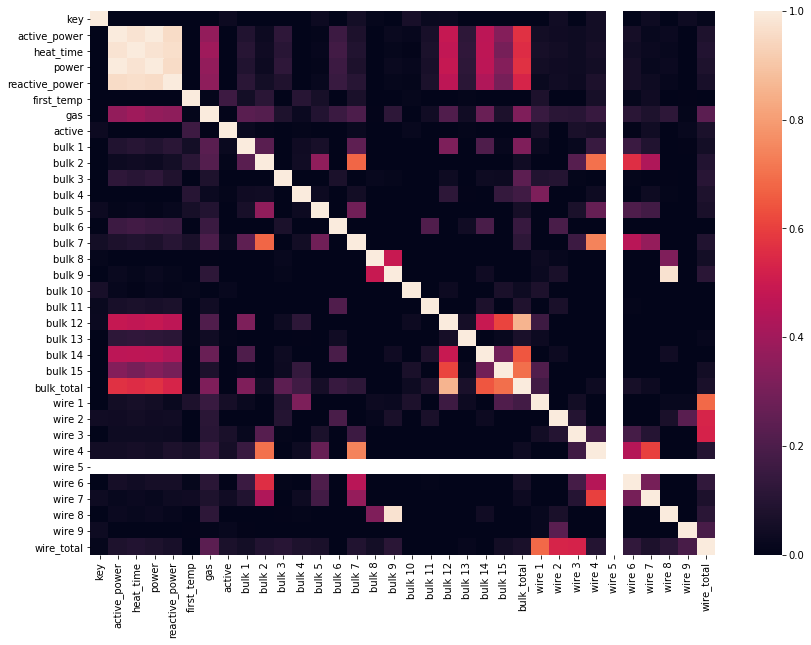

In [71]:
corr = X.corr()
plt.rcParams['figure.figsize'] = (14,10)
ax = sns.heatmap(corr, vmin=0, vmax=1)

### Корректировка

По данным heatmap наибольшая корреляция отмечается между показателями мощности: active_power, reactive_power, power, heat_time; а так же между bulk 9 & wire 8.

In [72]:
wire = X['wire 8'].sum()/X['wire_total'].sum()

In [73]:
print('Доля проволоки 8: {:.3%}'.format(wire))

Доля проволоки 8: 0.258%


In [74]:
bulk = X['bulk 9'].sum()/X['bulk_total'].sum()

In [75]:
print('Доля присадки 9: {:.3%}'.format(bulk))

Доля присадки 9: 0.075%


Удаляю по предположительной степени значимости для будущей модели.

In [76]:
X = X.drop(['reactive_power', 'wire 8', 'power', 'heat_time'], 1)

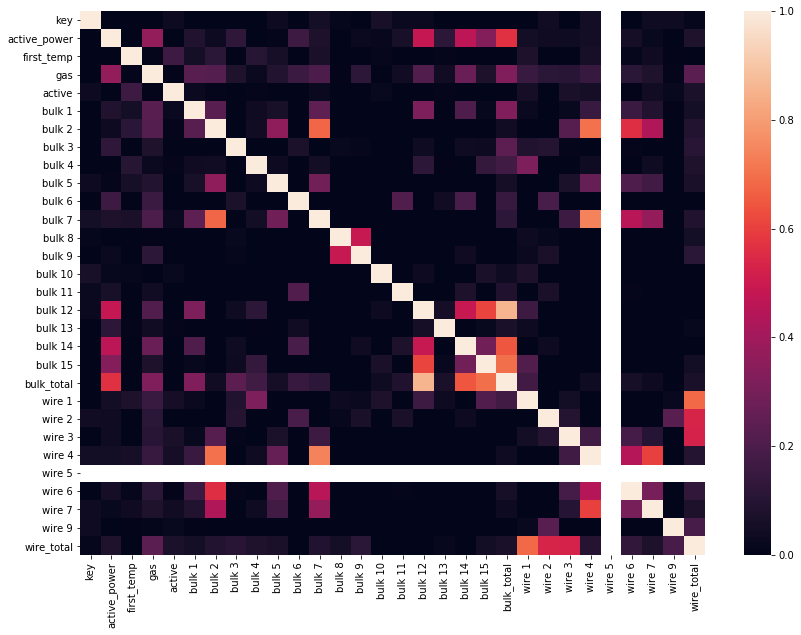

In [77]:
corr = X.corr()
ax = sns.heatmap(corr, vmin=0, vmax=1)

In [78]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2346 entries, 0 to 2476
Data columns (total 30 columns):
key             2346 non-null int64
active_power    2346 non-null float64
first_temp      2346 non-null float64
gas             2346 non-null float64
active          2346 non-null float64
bulk 1          2346 non-null float64
bulk 2          2346 non-null float64
bulk 3          2346 non-null float64
bulk 4          2346 non-null float64
bulk 5          2346 non-null float64
bulk 6          2346 non-null float64
bulk 7          2346 non-null float64
bulk 8          2346 non-null float64
bulk 9          2346 non-null float64
bulk 10         2346 non-null float64
bulk 11         2346 non-null float64
bulk 12         2346 non-null float64
bulk 13         2346 non-null float64
bulk 14         2346 non-null float64
bulk 15         2346 non-null float64
bulk_total      2346 non-null float64
wire 1          2346 non-null float64
wire 2          2346 non-null float64
wire 3          2346 

## Модели

### Разделение выборки на train & test

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1024)

In [80]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1876, 30), (470, 30), (1876,), (470,))

Разбивка данных, корректно.

### Масштабирование

In [81]:
strd_scaler = StandardScaler()

In [82]:
X_train = strd_scaler.fit_transform(X_train)
X_test = strd_scaler.transform(X_test)

### Features importances

Оценку значимости признаков оценю на линейной регрессии.

In [83]:
lr = LinearRegression(n_jobs=-1)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [84]:
lr_pred = lr.predict(X_test)
print(mean_absolute_error(y_test, lr_pred))

7.932299974621325


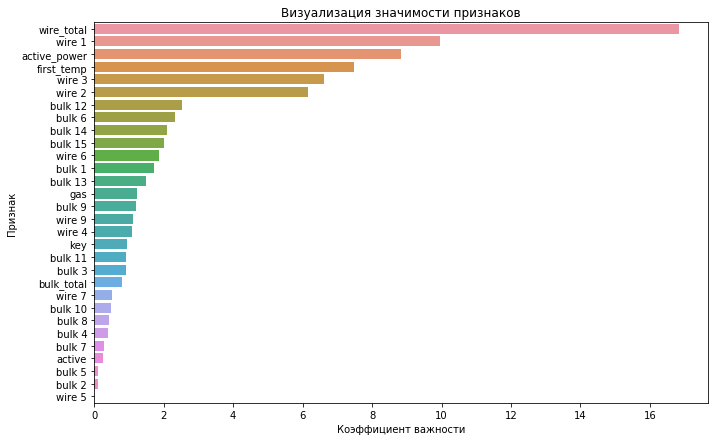

In [85]:
def coef(model):
    coef = pd.Series(np.abs(model.coef_), index=X.columns).sort_values(ascending=False)
    plt.rcParams['figure.figsize'] = (11,7)
    ax = sns.barplot(x=coef, y=coef.index)
    ax.set(xlabel='Коэффициент важности', ylabel='Признак')
    ax.set_title('Визуализация значимости признаков')
    
coef(lr)

При анализе визуализации выделяется группа признаков с низким коэффициентом важности: wire 7 и ниже (всего 9 признаков), - удаляю.

In [86]:
X_1 = X.drop(['wire 7', 'bulk 10', 'bulk 8', 'bulk 4', 'bulk 7', 'active', 'bulk 5', 'bulk 2', 'wire 5',], axis=1)

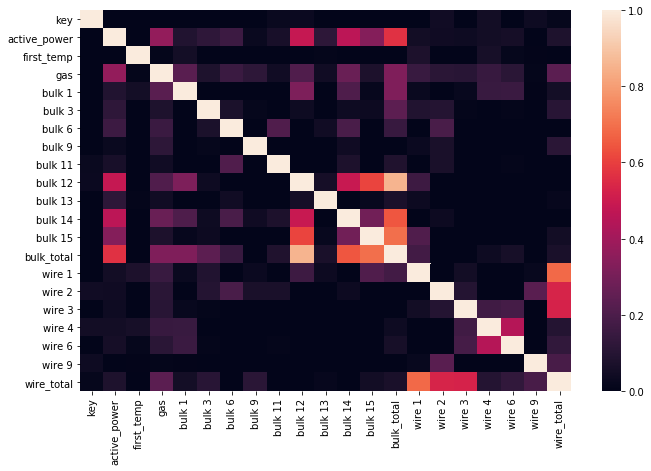

In [87]:
corr_1 = X_1.corr()
ax = sns.heatmap(corr_1, vmin=0, vmax=1)

In [88]:
X_1.head()

,key,active_power,first_temp,gas,bulk 1,bulk 3,bulk 6,bulk 9,bulk 11,bulk 12,...,bulk 14,bulk 15,bulk_total,wire 1,wire 2,wire 3,wire 4,wire 6,wire 9,wire_total
0,1,4.878147,1571.0,29.749986,0.0,0.0,0.0,0.0,0.0,206.0,...,150.0,154.0,553.0,60.059998,0.00000,0.0,0.0,0.0,0.0,60.059998
1,2,3.052598,1581.0,12.555561,0.0,0.0,0.0,0.0,0.0,206.0,...,149.0,154.0,582.0,96.052315,0.00000,0.0,0.0,0.0,0.0,96.052315
2,3,2.525882,1596.0,28.554793,0.0,0.0,0.0,0.0,0.0,205.0,...,152.0,153.0,544.0,91.160157,0.00000,0.0,0.0,0.0,0.0,91.160157
3,4,3.209250,1601.0,18.841219,0.0,0.0,0.0,0.0,0.0,207.0,...,153.0,154.0,595.0,89.063515,0.00000,0.0,0.0,0.0,0.0,89.063515
4,5,3.347173,1576.0,5.413692,0.0,0.0,0.0,0.0,0.0,203.0,...,151.0,152.0,584.0,89.238236,9.11456,0.0,0.0,0.0,0.0,98.352796


In [89]:
X_1_train, X_1_test, y_train, y_test = train_test_split(X_1, y, test_size=0.2, random_state=1024)

In [90]:
X_1_train = strd_scaler.fit_transform(X_1_train)
X_1_test = strd_scaler.transform(X_1_test)

Повторное разделение и масштабирование.

### DummyRegressor

In [91]:
%%time
dr = DummyRegressor(strategy='mean')
dr.fit(X_1_train, y_train)
dr_pred = dr.predict(X_1_test)
print('MAE для DummyRegressor: {:.2f}'.format(mean_absolute_error(y_test, dr_pred)))

MAE для DummyRegressor: 10.00
CPU times: user 1.4 ms, sys: 170 µs, total: 1.57 ms
Wall time: 1.26 ms


### LinearRegression

In [92]:
lr = LinearRegression()
lr_par = {
    'fit_intercept' : [True, False],
    'copy_X': [True, False],
    'n_jobs' :[None, -1],
    'normalize' : [True, False]
}
lr_grid = GridSearchCV(estimator=lr, param_grid=lr_par,  cv=5, scoring='neg_mean_absolute_error')

In [93]:
%%time
lr_grid.fit(X_1_train, y_train)
print('Лучшие параметры: ', lr_grid.best_params_)
print('MAE для Linear Regresion: {:.2f}'.format(np.abs(lr_grid.best_score_)))

Лучшие параметры:  {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': True}
MAE для Linear Regresion: 7.98
CPU times: user 731 ms, sys: 612 ms, total: 1.34 s
Wall time: 1.31 s


### RandomForest

In [94]:
rfr = RandomForestRegressor(n_jobs=-1, random_state=1024)
rfr_par = {
    'max_depth': [4,8,10],
    'n_estimators': [400, 500, 600, 800],
    'min_samples_split': range(2, 5)
}
rfr_grid = GridSearchCV(estimator=rfr, param_grid=rfr_par, cv=5, scoring = 'neg_mean_absolute_error')

In [95]:
#%%time
#rfr_grid.fit(X_1_train, y_train)
#print('Лучшие параметры: ', rfr_grid.best_params_)
#print('MAE для RandomForestRegressor: {:.2f}'.format(np.abs(rfr_grid.best_score_)))

Лучшие параметры:  {'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 400}

MAE для RandomForestRegressor: 6.26

CPU times: user 14min 22s, sys: 233 ms, total: 14min 23s

Wall time: 14min 35s

###  KNeighborsRegressor

In [96]:
knr = KNeighborsRegressor()
knr_par = {
    'n_neighbors': range(2,10),
    'n_jobs': [None,-1],
    'weights': ['uniform', 'distance']
}
knr_grid = GridSearchCV(estimator=knr, param_grid=knr_par, cv=5, scoring = 'neg_mean_absolute_error')

In [97]:
#%%time
#knr_grid.fit(X_1_train, y_train)
#print('Лучшие параметры: ', knr_grid.best_params_)
#print('MAE для KNeighborsRegressor: {:.2f}'.format(np.abs(knr_grid.best_score_)))

Лучшие параметры:  {'n_jobs': None, 'n_neighbors': 2, 'weights': 'distance'}

MAE для KNeighborsRegressor: 6.25

CPU times: user 37.9 s, sys: 0 ns, total: 37.9 s

Wall time: 40.1 s

### Cat Boost Regressor

In [98]:
#%%time
#train_dataset = cb.Pool(X_1_train, y_train)
#cbr = cb.CatBoostRegressor(loss_function='RMSE', random_state = 1024)

#grid = {
#    'iterations': [150, 200, 500],
#    'learning_rate': [0.003, 0.3, 0.1],
#    'depth': [4, 6, 8, 10]
#}
#cbr.grid_search(grid, train_dataset)

35:	loss: 63.7629209	best: 13.9577384 (8)	total: 6m 52s	remaining: 0us

Estimating final quality...

CPU times: user 6min 43s, sys: 25.9 s, total: 7min 9s

Wall time: 7min 39s

In [99]:
#%%time
#cbr_predict = cbr.predict(X_1_test)
#cbr_mae = np.abs(mean_absolute_error(cbr_predict, y_test))
#print('MAE для CatBoostRegressor: {:.2f}'.format(cbr_mae))

MAE для CatBoostRegressor: 5.64

CPU times: user 9.15 ms, sys: 319 µs, total: 9.47 ms

Wall time: 3.39 ms

### Сводная таблица

In [100]:
d = {
    'DummyRegressor': [10.00],
    'LinearRegression' : [7.98],
    'RandomForest' : [6.26],
    'KNeighborsRegressor' : [7.08],
    'CatBoostRegressor' : [5.64]
    }
resume = pd.DataFrame(data=d, index=['MAE'], dtype=np.int64)

## Вывод

In [101]:
resume

,DummyRegressor,LinearRegression,RandomForest,KNeighborsRegressor,CatBoostRegressor
MAE,10,7.98,6.26,7.08,5.64


Модели по качеству расположились в следующем порядке: CatBoostRegressor, RandomForest, KNeighborsRegressor, LinearRegression.

Итак, метрика МАЕ лучшей модели (CatBoostRegressor) составляет 5,64.

Все используемые модели достигли необходимого результата и показали метрику лучше 8.

## Отчёт по решению

- В проведенном исследовании все пункты плана исследования были выполнены в полном объеме.

- На этапе определения взаимосвязи между признаками и целевым показателем возникли трудности с подбором необходимых признаков, в частности, данные о времени. Данные признаки были частично (не из всех таблиц) использованы для формирования актуального финального датасета, проводился сравнительный анализ технологических процессов по времени наступления, при выявлении несоответствия, данные о партии исключались из исследования. На этапе объединения исходных данных возникла проблема дублирования партий и, как следствие, увеличение количественных признаков. Проблема была решена перепроверкой методов объединения таблиц.

- Ключевые шаги исследования:
    - подготовка качественно объединенных данных, генерирование новых признаков;
    - уменьшение мультиколлинеарности;
    - поиск и использование наиболее значимых признаков;
    - подбор и настройка моделей;
    - оценка результатов.
    
- Итоговая модель - CatBoostRegressor. Качество: МАЕ 5,64.